## 1. Libraries and data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [23]:
train = pd.read_csv('Data/our_train.csv')
test = pd.read_csv('Data/our_test.csv')
val = pd.read_csv('Data/our_val.csv')

In [24]:
X_train = train.drop('NObeyesdad', axis=1)
y_train = train['NObeyesdad']
X_test = test.drop('NObeyesdad', axis=1)
y_test = test['NObeyesdad']
X_val = val.drop('NObeyesdad', axis=1)
y_val = val['NObeyesdad']

In [25]:
CAEC_dict = {'no': 0, 'Sometimes': 0.33, 'Frequently': 0.66, 'Always': 1 }
CALC_dict = {'no': 0, 'Sometimes': 0.5, 'Frequently': 1}

In [26]:
X_train['CAEC'] = X_train['CAEC'].map(CAEC_dict)
X_train['CALC'] = X_train['CALC'].map(CALC_dict)
X_test['CAEC'] = X_test['CAEC'].map(CAEC_dict)
X_test['CALC'] = X_test['CALC'].map(CALC_dict)
X_val['CAEC'] = X_val['CAEC'].map(CAEC_dict)
X_val['CALC'] = X_val['CALC'].map(CALC_dict)

In [27]:
cat_cols2 = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']

## 2. New features
Let's create new feature - BMI index.

In [28]:
def calculate_bmi(data):
    data['BMI'] = data['Weight'] / (data['Height'] ** 2)
    return data.drop(['Weight', 'Height', 'id'], axis=1)

In [29]:
pipeline = Pipeline([
    ('calculate_bmi', FunctionTransformer(calculate_bmi)),
])

In [30]:
# creating a new column bmi 
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)
X_val = pipeline.transform(X_val)

In [31]:
X_train

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,BMI
0,Male,32.000000,yes,no,2.000000,3.000000,0.33,no,1.000000,no,0.000000,2.000000,0.5,Automobile,39.183673
1,Female,19.783234,yes,yes,3.000000,3.000000,0.33,no,2.835622,no,1.655488,0.816986,0.5,Public_Transportation,40.325664
2,Male,21.793724,yes,yes,2.921225,2.983201,0.33,no,2.184843,no,2.164472,0.000000,0.5,Public_Transportation,28.499889
3,Female,21.000000,yes,yes,2.000000,3.000000,0.33,no,2.000000,no,1.000000,2.000000,0.5,Public_Transportation,23.665244
4,Female,25.470652,yes,yes,3.000000,3.000000,0.33,no,2.554007,no,0.025787,0.484165,0.5,Public_Transportation,40.504193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14525,Female,18.000000,yes,yes,2.628791,2.562895,0.33,no,1.844645,no,0.288032,0.722276,0.0,Public_Transportation,27.113666
14526,Male,22.000000,yes,no,3.000000,3.000000,0.33,no,2.000000,no,3.000000,0.000000,0.5,Public_Transportation,31.020408
14527,Male,21.000000,no,yes,2.000000,3.000000,1.00,no,3.000000,no,2.000000,0.000000,0.5,Public_Transportation,25.910684
14528,Female,26.000000,yes,yes,3.000000,3.000000,0.33,no,2.770732,no,0.000000,0.237307,0.5,Public_Transportation,41.110271


In [32]:
X_train.columns

Index(['Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'FCVC',
       'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS',
       'BMI'],
      dtype='object')

In [33]:
cols_numerical = [ 'Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'FCVC',
       'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS',
       'BMI']

In [34]:
#change categorical columns to numerical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in cat_cols2:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.fit_transform(X_test[col])
    X_val[col] = le.fit_transform(X_val[col])

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

Before normalization let's take a look at variance of features.

In [35]:
X_train.var()

Gender                             0.250013
Age                               32.842358
family_history_with_overweight     0.146931
FAVC                               0.079089
FCVC                               0.284201
NCP                                0.492681
CAEC                               0.022627
SMOKE                              0.011765
CH2O                               0.367794
SCC                                0.032845
FAF                                0.707664
TUE                                0.365470
CALC                               0.055946
MTRANS                             1.325107
BMI                               69.468236
dtype: float64

There are no features with variance equal to 0. No need to cross them out.

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [37]:
X_train = pd.DataFrame(X_train, columns=cols_numerical)
X_test = pd.DataFrame(X_test, columns=cols_numerical)
X_val = pd.DataFrame(X_val, columns=cols_numerical)

In [38]:
y_val = pd.DataFrame(y_val, columns=['NObeyesdad'])
y_train = pd.DataFrame(y_train, columns=['NObeyesdad'])
y_test = pd.DataFrame(y_test, columns=['NObeyesdad'])

In [39]:
train_with_BMI = pd.concat([X_train, y_train], axis=1)
test_with_BMI = pd.concat([X_test, y_test], axis=1)
val_with_BMI = pd.concat([X_val, y_val], axis=1)

In [40]:
train_with_BMI.to_csv('Data/train_with_BMI.csv', index=False)
test_with_BMI.to_csv('Data/test_with_BMI.csv', index=False)
val_with_BMI.to_csv('Data/val_with_BMI.csv', index=False)

## 3. Feature imporatance
### 3.1. Random forest classifier feature importance score.

In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier


rf_classifier = RandomForestClassifier(n_estimators=300, random_state=42)

# Fit the classifier to your training data
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top features
print("Top Features:")
print(feature_importance_df.head(12))


Top Features:
                           Feature  Importance
14                             BMI    0.430758
1                              Age    0.112101
4                             FCVC    0.090918
0                           Gender    0.055327
11                             TUE    0.053261
8                             CH2O    0.051638
10                             FAF    0.048412
5                              NCP    0.036248
2   family_history_with_overweight    0.030544
6                             CAEC    0.027865
12                            CALC    0.026398
13                          MTRANS    0.016942


### 3.2. XGBoost Classifier feature importance score

In [18]:
import pandas as pd
import xgboost as xgb


# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=42, learning_rate= 0.1, n_estimators = 600)

# Fit the classifier to your training data
xgb_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = xgb_classifier.feature_importances_

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top features
print("Top Features:")
print(feature_importance_df.head(15))


Top Features:
                           Feature  Importance
0                           Gender    0.322387
14                             BMI    0.285097
3                             FAVC    0.046712
4                             FCVC    0.042683
9                              SCC    0.034447
12                            CALC    0.032058
13                          MTRANS    0.030184
1                              Age    0.029991
5                              NCP    0.029507
2   family_history_with_overweight    0.028606
8                             CH2O    0.026450
6                             CAEC    0.026385
11                             TUE    0.023658
10                             FAF    0.021324
7                            SMOKE    0.020512


### 3.3. Gini score

In [52]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='gini', random_state=42)
clf.fit(X_train, y_train)

feature_importances = clf.feature_importances_

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top features
print("Top Features:")
print(feature_importance_df.head(15))

Top Features:
                           Feature  Importance
14                             BMI    0.696627
0                           Gender    0.068970
1                              Age    0.057954
4                             FCVC    0.030411
8                             CH2O    0.026238
10                             FAF    0.025781
11                             TUE    0.021122
5                              NCP    0.020138
12                            CALC    0.012678
6                             CAEC    0.010555
3                             FAVC    0.009303
13                          MTRANS    0.008227
2   family_history_with_overweight    0.007430
9                              SCC    0.003753
7                            SMOKE    0.000813


Similarily to XGB, Gini recognizes BMI and Gender as the most important features in our model. Since only 3 features have Gini >= 0.05, we will cross out the last feature only.

## 4. Selected features 

In [19]:
selected_features = [
    'Gender', 
    'BMI', 
    'FCVC', 
    'FAVC',
    'SCC',
    'CALC',
    'MTRANS',
    'Age',
    'family_history_with_overweight',
    'FAF',
    'NCP'
]

In [20]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
X_val_selected = X_val[selected_features]

In [21]:
X_train_selected.shape

(14530, 11)

In [22]:
model = XGBClassifier(random_state = 1, learning_rate = 0.01, max_depth = 6, n_estimators = 1600)
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_val_selected)
class_report1 = classification_report(y_val, y_pred)
print("Classification Report:\n", class_report1)
conf_matrix1 = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix1)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92       525
           1       0.83      0.87      0.85       624
           2       0.85      0.81      0.83       604
           3       0.94      0.96      0.95       714
           4       0.99      1.00      1.00       837
           5       0.75      0.74      0.74       532
           6       0.75      0.75      0.75       523

    accuracy                           0.88      4359
   macro avg       0.86      0.86      0.86      4359
weighted avg       0.88      0.88      0.88      4359


Confusion Matrix:
[[477  43   0   0   0   3   2]
 [ 29 544   1   0   0  42   8]
 [  2   3 492  30   4  24  49]
 [  0   0  23 682   1   0   8]
 [  1   0   0   1 834   0   1]
 [  0  54  18   0   0 395  65]
 [  0  11  45  10   0  65 392]]


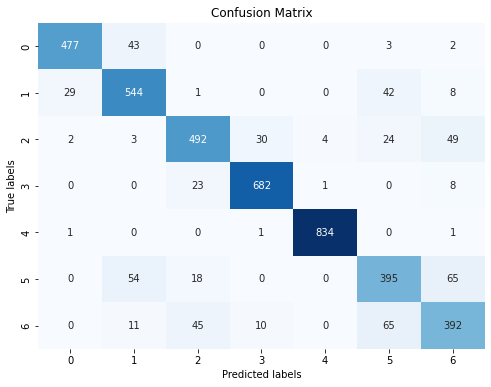

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()